In [21]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten

In [22]:
def load_and_prepare_data(file_path, lookback=60, model_type="LSTM"):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    
    if model_type == "LIGHTGBM":
        # Add technical + date features
        df['MA_5'] = df['Close'].rolling(window=5).mean()
        df['MA_10'] = df['Close'].rolling(window=10).mean()
        df['Momentum'] = df['Close'] - df['Close'].shift(5)
        df['Volatility'] = df['Close'].rolling(window=5).std()
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['Month'] = df['Date'].dt.month

        # Add lag features
        for lag in range(1, lookback + 1):
            df[f'Lag_{lag}'] = df['Close'].shift(lag)

        df.dropna(inplace=True)

        feature_cols = [f'Lag_{i}' for i in range(1, lookback + 1)] + [
            'MA_5', 'MA_10', 'Momentum', 'Volatility', 'DayOfWeek', 'Month'
        ]

        X = df[feature_cols].values
        y = df['Close'].values

        return X, y, None, df

    else:  # LSTM
        data = df[['Close']].values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)

        X, y = [], []
        for i in range(lookback, len(scaled_data)):
            X.append(scaled_data[i - lookback:i, 0])
            y.append(scaled_data[i, 0])

        X = np.array(X)
        y = np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # shape for LSTM
        return X, y, scaler, df


In [23]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [24]:
def train_lightgbm_model(X_train, y_train, X_test, y_test):
    best_model = None
    best_rmse = float('inf')
    best_params = {}

    param_grid = {
        'num_leaves': [15, 31, 50],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_samples': [10, 20],
        'lambda_l2': [0.0, 0.1]
    }

    for num_leaves in param_grid['num_leaves']:
        for lr in param_grid['learning_rate']:
            for min_child in param_grid['min_child_samples']:
                for l2 in param_grid['lambda_l2']:
                    params = {
                        'objective': 'regression',
                        'metric': 'l2',
                        'learning_rate': lr,
                        'num_leaves': num_leaves,
                        'min_child_samples': min_child,
                        'lambda_l2': l2,
                        'verbose': -1,
                        'seed': 42
                    }

                    train_data = lgb.Dataset(X_train, label=y_train)
                    valid_data = lgb.Dataset(X_test, label=y_test)

                    booster = lgb.train(
                        params=params,
                        train_set=train_data,
                        num_boost_round=100,
                        valid_sets=[valid_data],
                        valid_names=['valid'],
                        callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
                    )

                    preds = booster.predict(X_test, num_iteration=booster.best_iteration)
                    rmse = np.sqrt(mean_squared_error(y_test, preds))

                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_model = booster
                        best_params = params

    print("Best LightGBM params:", best_params)
    print("Best RMSE:", round(best_rmse, 4))
    return best_model

In [25]:
def train_and_evaluate(file_path, stock_name, model_type="LSTM"):
    print(f"\nTraining model for {stock_name} using {model_type}")
    lookback = 60
    X, y, scaler, df = load_and_prepare_data(file_path, lookback, model_type=model_type)

    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    history = None

    if model_type == "LSTM":
        model = build_lstm_model((lookback, 1))
        history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                            validation_data=(X_test, y_test), verbose=1)
        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)

        # Inverse transform both y and predictions
        train_predictions = scaler.inverse_transform(train_predictions)
        train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
        test_predictions = scaler.inverse_transform(test_predictions)
        test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    elif model_type == "LIGHTGBM":
        X_train_flat = X_train.reshape((X_train.shape[0], X_train.shape[1]))
        X_test_flat = X_test.reshape((X_test.shape[0], X_test.shape[1]))

        booster = train_lightgbm_model(X_train_flat, y_train, X_test_flat, y_test)
        train_predictions = booster.predict(X_train_flat, num_iteration=booster.best_iteration).reshape(-1, 1)
        test_predictions = booster.predict(X_test_flat, num_iteration=booster.best_iteration).reshape(-1, 1)

        # y is already in actual price form for LightGBM
        train_actual = y_train.reshape(-1, 1)
        test_actual = y_test.reshape(-1, 1)

    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Train metrics
    train_mse = mean_squared_error(train_actual, train_predictions)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(train_actual, train_predictions)
    train_r2 = r2_score(train_actual, train_predictions)

    # Test metrics
    test_mse = mean_squared_error(test_actual, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(test_actual, test_predictions)
    test_r2 = r2_score(test_actual, test_predictions)

    # Plot metrics table
    fig, ax = plt.subplots(figsize=(7.5, 3))
    ax.axis('tight')
    ax.axis('off')

    comparison_table = [
        ["Metric", "Train", "Test"],
        ["MSE", f"{train_mse:.4f}", f"{test_mse:.4f}"],
        ["RMSE", f"{train_rmse:.4f}", f"{test_rmse:.4f}"],
        ["MAE", f"{train_mae:.4f}", f"{test_mae:.4f}"],
        ["R² Score", f"{train_r2:.4f}", f"{test_r2:.4f}"]
    ]

    table = ax.table(cellText=comparison_table, cellLoc='center', loc='center')
    table.scale(1.2, 2)
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    plt.title(f"{stock_name} - {model_type} Metrics", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Plot training loss (LSTM only)
    if history:
        plt.figure(figsize=(10, 4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f"{stock_name} {model_type} Training Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (MSE)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Plot actual vs predicted prices
    plt.figure(figsize=(10, 4))
    plt.plot(test_actual, label='Actual Price')
    plt.plot(test_predictions, label='Predicted Price')
    plt.title(f"{stock_name} {model_type} - Predicted vs Actual Closing Price")
    plt.xlabel("Days")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save predictions
    prediction_dates = df['Date'].iloc[len(df) - len(y_test):].reset_index(drop=True)
    prediction_df = pd.DataFrame({
        'Date': prediction_dates,
        'Actual Price': test_actual.flatten(),
        'Predicted Price': test_predictions.flatten()
    })
    prediction_df['Year'] = prediction_df['Date'].dt.year
    output_path = f"data/output/predictions_{stock_name}_{model_type}.csv"
    prediction_df.to_csv(output_path, index=False)

    return test_predictions, test_actual


Training model for SPY using LSTM
Epoch 1/20


/opt/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0053 - val_loss: 3.5541e-04
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2774e-05 - val_loss: 4.6696e-04
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7522e-05 - val_loss: 4.8190e-04
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7687e-05 - val_loss: 3.2478e-04
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.5276e-05 - val_loss: 3.0310e-04
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.5604e-05 - val_loss: 5.2828e-04
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.2246e-05 - val_loss: 3.0971e-04
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.3090e-05 - val_loss: 3.3265e-04
Epoch 9/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.6962e-05 - val_loss: 2.9091e-04
Epoch 10/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3831e-05 - val_loss: 2.6962e-04
Epoch 11/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9759e-05 - 

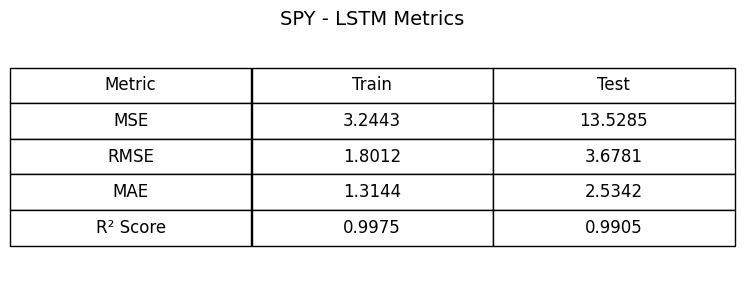

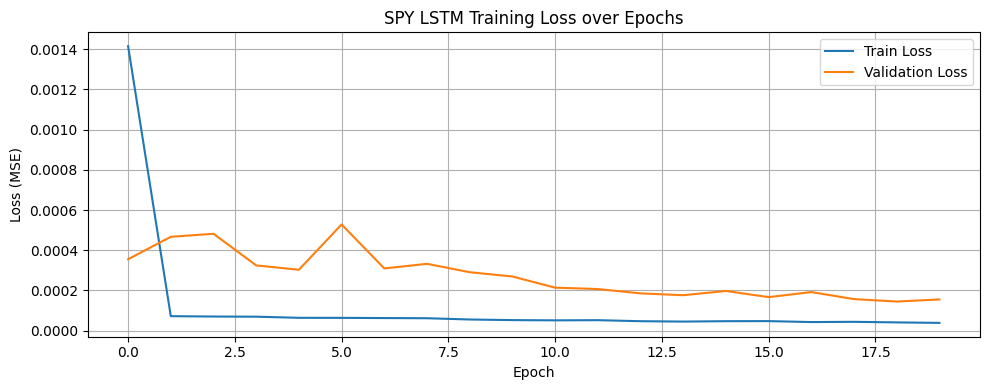

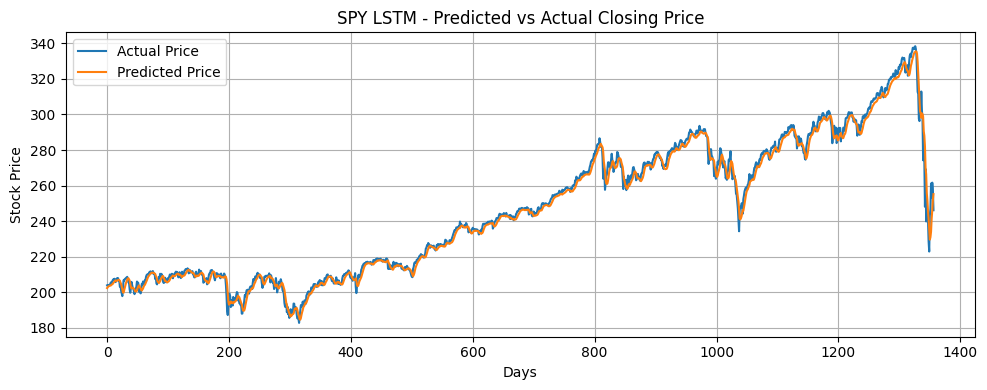


Training model for SPY using LIGHTGBM
Best LightGBM params: {'objective': 'regression', 'metric': 'l2', 'learning_rate': 0.1, 'num_leaves': 50, 'min_child_samples': 10, 'lambda_l2': 0.1, 'verbose': -1, 'seed': 42}
Best RMSE: 59.524


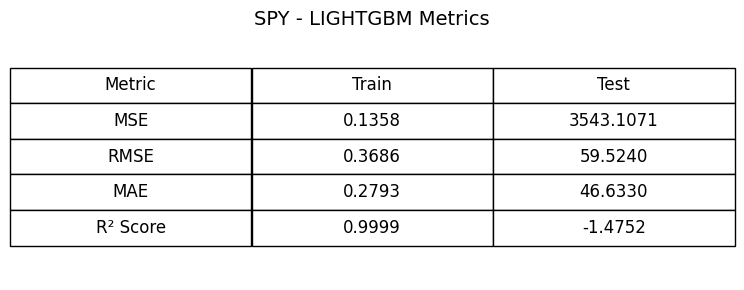

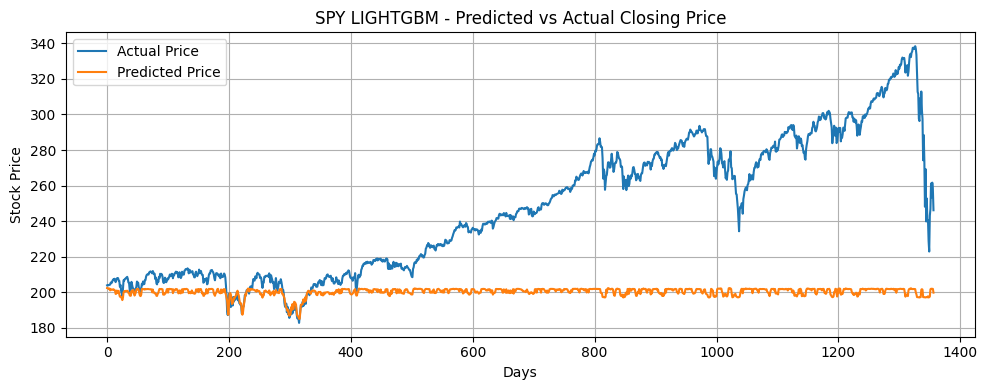

In [26]:
# Train both models for SPY
spy_lstm_pred, spy_lstm_actual = train_and_evaluate("data/stocks/SPY.csv", "SPY", model_type="LSTM")
spy_lgbm_pred, spy_lgbm_actual = train_and_evaluate("data/stocks/SPY.csv", "SPY", model_type="LIGHTGBM")